In [1]:
import numpy as np
import random
from copy import deepcopy
from matplotlib.pyplot import imshow
from IPython.display import display
from PIL import Image
import copy
import os     
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin'
import graphviz
import hashlib

def generate_target_image_matrix(filepath):
    '''
    Open the UTAR logo file (must be 300-by-150 in pixels) at `filepath` and
    chop it into 9 sub-images of equal size (leaving top-left empty). These
    sub-images are saved into a list of lists (representing 3-by-3 matrix).
    
    Note - Numpy nd-arrays aren't used because they cannot hold Images as
    elements.
    '''
    im = Image.open(filepath)
    images = np.zeros(shape=(3, 3))
    images = images.tolist()
    for r in range(3):
        for c in range(3):
            if r+c > 0:  # The top-left box is left empty to allow moving
                box = (c*100, r*50, (c+1)*100, (r+1)*50)
                images[r][c] = im.crop(box)
    return images

def display_single_image(images):
    '''
    Take the 3-by-3 'matrix' of images and display it as one image (with a
    2-pixel gap to indicate where the sub-images are). Does not return any
    value.
    
    Note - By definition for this puzzle there must always be an empty
    element in the 3-by-3 matrix.
    '''
    im = Image.new(mode='RGB', size=(304, 154), color=(255,255,255))
    for r in range(3):
        for c in range(3):
            if images[r][c]:  # Check if there's a sub-image here
                box = (c*102, r*52, c*102+100, r*52+50)
                im.paste(images[r][c], box)
    display(im)

def shift_image_matrix_once(images, loc=None):
    '''
    Take the 3-by-3 'matrix' of images and do one movement, returning
    the resulting 3-by-3 'matrix' of images. If `loc` is None (default)
    then this randomly chooses a valid movement.
    '''
    for r in range(3):
        for c in range(3):
            if not images[r][c]:  # Found the empty slot!
                empty_loc = (r, c)
                target_loc = [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]
    # target_loc lists the locations which are valid sub-images to be
    # moved into this empty slot (so -1 and 3 aren't valid coordinates)
    target_loc = [(r, c) for (r, c) in target_loc
                 if r > -1 and c > -1 and r < 3 and c < 3]
    if loc == None:  # Default behaviour, shift a random piece
        target_loc = random.choice(target_loc)
    else:  # Shift a given target to the empty location
        if loc in target_loc:
            target_loc = loc
        else:  # If an invalid loc is specified, return an error
            raise ValueError("The location '{}' is not adjacent to the empty location '{}'"
                            .format(loc, empty_loc))
    rO, cO = empty_loc
    rT, cT = target_loc
    images[rO][cO], images[rT][cT] = images[rT][cT], images[rO][cO]
    return images

def shuffle_image_matrix_n_times(images, n):
    '''
    Take the 3-by-3 'matrix' of images and a number n, which is the number of times
    to shuffle the puzzle. Returns the shuffled puzzle.
    '''
    for i in range(n):
        images = shift_image_matrix_once(images)
    return images

def apply_solution_to_image_matrix(images, solution):
    '''
    Apply a solution (formulated as a list of locations to move) to a 'matrix' of
    images. If the solution is correct, the resulting/returned 'matrix' should be
    identical to the target 'matrix', showing the UTAR logo.
    '''
    images = deepcopy(images)  # To allow multiple calls to this function
    for loc in solution:
        images = shift_image_matrix_once(images, loc=loc)
    return images

def pick_uninformed_search_method():
    l = ['Breadth-first Search',
         'Depth-first Search',
         'Bidirectional Search',
         'Uniform-cost Search',
         'Iterative Deepening']
    return random.choice(l)

def initialize_random_seed(id_number):
    if isinstance(id_number, str):
        raise TypeError("Please provide the digits of your ID number only.")
    if len(str(id_number)) != 7:
        raise ValueError("Please provide the seven (7) digits of your ID number.")
    random.seed(id_number)

'The target image'

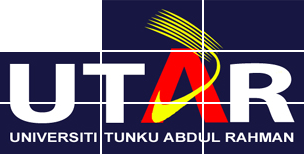

'Your randomly generated starting point'

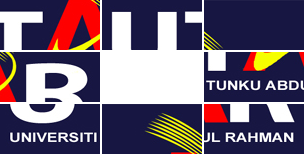

"Your randomly generated uninformed search method is 'Iterative Deepening'"

In [2]:
initialize_random_seed(1704367)  # Insert your ID number here as a 7-digit integer
images = generate_target_image_matrix('UTARLogo.png')
display("The target image")
display_single_image(images)
display("Your randomly generated starting point")
starting_point = shuffle_image_matrix_n_times(images, 100)  # Do not change this number
display_single_image(starting_point)
display("Your randomly generated uninformed search method is '{}'".format(pick_uninformed_search_method()))

#############################################

! The original 3rd cell has been moved to final cell !
#############################################

In [3]:
# ___________________
#unique class to contain node details
# ___________________

class Node:
    def __init__(self,image,parent=None,loc=None,depth=None):
        self.image = image
        self.parent = parent
        self.child = []
        #Loc is the location of empty block
        if(loc == None):
            self.loc = self.FindEmptyLoc()
        else:
            self.loc = loc 
        if depth == None :
            self.depth = parent.depth+1
        else:
            self.depth = depth
    
    def AddChild(self,childNode):
        self.child.append(childNode)   
        
    def FindEmptyLoc(self):
        for r in range(3):
            for c in range(3):
                if not self.image[r][c]:  # Found the empty slot!
                    emptyLoc = (r, c)
                    return emptyLoc
                
    #Frees children instances. To prevent instance where children unintentionally
    #carried forward for next iteration as dynamic programming is not used
    def FreeChildren(self):
        self.child = []

In [4]:
# ___________________
# IDDFS to create children as they search/traverse
# Tree(s) generated are different based on depth
# ___________________

class Algo:
    def __init__(self,target,root,maxDepth,maxNodes=999999):
        self.traversedCountList = []
        self.target   = target
        self.rootNode = root
        self.maxDepth = maxDepth
        self.maxNodes = maxNodes
        self.solutionFound = False
        
        #Dictionary to prevent duplication of child. 
        self.imageDict = dict()
        
        global solutionNode
        solutionNode = None
    
    # DFS part of IDDFS. Creates child & find solution while < maxDepth or maxNodes
    def IDDFSDepthSearch(self,currentNode,iterationMaxDepth):
        global numberOfNodes, solutionNode
        
        if(self.solutionFound):
            return True
        
        if(numberOfNodes < self.maxNodes and self.solutionFound!=True and currentNode.depth < iterationMaxDepth):
            (r,c) = copy.deepcopy(currentNode.loc)
            targetLocs = [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]
            targetLocs = [(r, c) for (r, c) in targetLocs if r > -1 and c > -1 and r < 3 and c < 3]
            for targetLoc in targetLocs:
                if(numberOfNodes < self.maxNodes and self.solutionFound != True and targetLoc!= currentNode.loc):
                    child = self.CreateChild(currentNode,currentNode.loc,targetLoc)
                    if(child != None):
                        self.subTraversedCountList += 1
                        if (child.image == self.target):
                            solutionNode = child
                            self.solutionFound = True
                            return True
                        if(child.depth < iterationMaxDepth):
                            self.IDDFSDepthSearch(child,iterationMaxDepth)
        else:
            return False
            
            
    #IDDFS is used to initialize the process,responsible for 'iterative' part of deepening
    def IDDFS(self,initialDepth=0):
        global numberOfNodes, solutionNode
        solutionNode = None
        self.traversedCountList = []
        self.solutionFound = False
        rootHash = copy.deepcopy(self.rootNode.image)
        rootHash = self.ConvertImageToHashableKey(rootHash)
        
        for currentDepth in range(initialDepth, self.maxDepth+1):
            if(self.solutionFound != True):
                print("Currently traversing IDDFS : {} " .format(currentDepth))
                self.rootNode.FreeChildren()
                self.imageDict.clear()
                self.subTraversedCountList = 1
                numberOfNodes = 1
                self.imageDict[rootHash] = self.rootNode

                #Attempt to find solution. If not found move to next depth.
                if(self.IDDFSDepthSearch(self.rootNode,currentDepth)):
                    self.traversedCountList.append(self.subTraversedCountList)
                    return True
                
                self.traversedCountList.append(self.subTraversedCountList)
    
    #Convert child image to hash, check for duplication? add child to parent : return None
    def CreateChild(self,parent,emptyLoc,targetLoc):
        childImage = copy.deepcopy(parent.image)
        rO, cO = emptyLoc
        rT, cT = targetLoc
        childImage[rO][cO], childImage[rT][cT] = childImage[rT][cT], childImage[rO][cO]
        x = copy.deepcopy(childImage)
        x = self.ConvertImageToHashableKey(x)
        
        #Do nothing and returns None if the image was created before
        if x in self.imageDict:
            return None
        else:
                child = Node(childImage,parent,targetLoc)
                parent.AddChild(child)
                self.imageDict[x] = child
                return child
    
    #Use the solution node to backtrack, creating list of nodes & steps to reach the target   
    def GetSolution(self):
        global solutionNode
        currentNode = copy.deepcopy(solutionNode)
        nodeList = []
        solutionList = []
        #Move upward until root node, root node does not have loc
        #Populates nodeList
        while(currentNode != None):
            nodeList.insert(0,currentNode)
            currentNode = currentNode.parent
        
        #Populates solutionList / list of steps
        for i in nodeList:
            if(i.parent != None):
                solutionList.append(i.loc)
        return nodeList,solutionList
    
    #Used by GetCompleteTree to loop child elements
    def GetCompleteTreeLoop(self,currentNode):
        for i in currentNode.child:
            self.completeTree.append(i)
            if(i.child != None):
                self.GetCompleteTreeLoop(i)
     
    #Returns list of generated nodes. Used for displaying the complete tree
    def GetCompleteTree(self):
        self.completeTree = []
        self.completeTree.append(self.rootNode)
        self.GetCompleteTreeLoop(self.rootNode)
        return self.completeTree
    
    #Getter. Used for coding clarity.
    def GetTraversedCountList(self):
        return self.traversedCountList
    
    #Ugly work around for 2d list to be hashable. Uses copy of image as parameter
    def ConvertImageToHashableKey(self, thisImage):
        tuple2D = []
        subTuple = []
        for subList in thisImage:
            for imagePart in subList:
                if(imagePart):
                    #Converts to hash string because i dont know other way to convert PIL image to hashable :))
                    imagePartHash = hashlib.md5(imagePart.tobytes()).hexdigest()
                    subTuple.append(imagePartHash)
                else:
                    subTuple.append(imagePart)
            subList = tuple(subTuple)
            tuple2D.append(subList)
        tuple2D = tuple(tuple2D)
        return tuple2D

In [5]:
# ___________________
# Visualization functions
# ___________________
# !! NOTE : THIS FUNCTION WILL VISUALIZE THE TREE BY CREATING JPEG FILES FROM NODELIST'S NODES, SAVING TO '/img'  !!
# !!        EACH NODE WILL CREATE AN 11KB FILE. ALL JPEG WILL BE MERGED AS ONE PDF FILE IN THE MAIN DIRECTORY     !!
# !!        FILE SIZE WILL INCREASE AT LARGE VOLUME OF NODES, AVOID RUNNING AT HIGH MAXDEPTH/MAXNODE(max depth>10)!!

class VisualizeTree():
    def __init__(self,saveFileName):
        self.itemDict = dict()
        self.saveFileName = saveFileName
    
    #Initialize tree imaging process from rootNode / tree
    def ReadFromRoot(self,rootNode):
        self.export = export = graphviz.Digraph(filename=str(saveFileName),node_attr={'shape':'plaintext'})
        self.CreateTreeFromRoot(rootNode)
    
    #Initialize tree imaging process from existing list containing nodes
    def ReadFromList(self,nodeList):
        self.nodeList = nodeList
        self.export = export = graphviz.Digraph(filename=str(saveFileName),node_attr={'shape':'plaintext'})
        self.CreateTreeFromList()
    
    #Used by CreateTreeFromRoot to create graph node
    def CreateNodeFromSingleNode(self,currentNode):
        self.CreateImage(currentNode.image).save( "methodB_img/" +str(id(i))+".JPEG","JPEG")
        newPath = "methodB_img/"+str(id(i))+".JPEG"
        self.export.node(str(id(i)),image=newPath,label="")
    
    #Create complete graph by recursion through child nodes
    def CreateTreeFromRoot(self,currentNode):
        self.itemDict.update({str(id(currentNode)):currentNode})
        self.CreateNodeFromSingleNode(currentNode)
        self.CreateNodeLinkage(currentNode)
        for i in currentNode.child:
            self.CreateNodeFromRoot(i)
    
    #Create complete graph by looping
    def CreateTreeFromList(self):
        for i in self.nodeList:
            self.itemDict.update({str(id(i)):i})
            self.CreateImage(i.image).save( "img/" +str(id(i))+".JPEG","JPEG")
            newPath = "img/"+str(id(i))+".JPEG"
            self.export.node(str(id(i)),image=newPath,label="")
        
        for i in self.nodeList:
            self.CreateNodeLinkage(i)
    
    #Link graph node to parent graph node
    def CreateNodeLinkage(self,currentNode):
        if(currentNode.parent != None):
            self.export.edge(str(id(currentNode.parent)),str(id(currentNode)))
    
    #Creates PIL image variable. Function is used by other function to save image file
    def CreateImage(self,image):
        im = Image.new(mode='RGB', size=(304, 154), color=(255,255,255))
        for r in range(3):
            for c in range(3):
                if image[r][c]:  # Check if there's a sub-image here
                    box = (c*102, r*52, c*102+100, r*52+50)
                    im.paste(image[r][c], box)
        return im
    
    #Export the tree in pdf
    def ExportPDF(self):
        self.export.view()    

In [6]:
# ___________________
# Q2(B)
# Sample of 40+ nodes
# ___________________

myMaxDepth = 5

startingPoint = copy.deepcopy(starting_point)
mainNode = Node(startingPoint,None,None,0)
myInitialDepth = 3
#myMaxNode = 40
targetImage = generate_target_image_matrix('UTARLogo.png')

myAlgo1 = Algo(targetImage,mainNode,myMaxDepth)
a1 = myAlgo1.IDDFS(myInitialDepth)

# ___________________
# Solution verification
# Creates the whole tree if no solution is found.
# ___________________
if(myAlgo1.solutionFound):
    print("Solution found : ")
else:
    print("No solution found")
    saveFileName = str('Q2B_InitialTree_depthOf{}'.format(myMaxDepth))
    tree = myAlgo1.GetCompleteTree()
    VT = VisualizeTree(saveFileName)
    VT.ReadFromList(tree)
    VT.ExportPDF()

# ___________________
#Print overview of IDDFS algorithm information
# ___________________
q2bTraversedList = myAlgo1.GetTraversedCountList()
totalTravelled = 0
for index, subList in enumerate(q2bTraversedList):
    print("Total nodes travelled in depth {} : {}" .format(myInitialDepth+index,subList))
    totalTravelled += subList
print("Total nodes travelled in this IDDFS : {}" .format(totalTravelled))

Currently traversing IDDFS : 3 
Currently traversing IDDFS : 4 
Currently traversing IDDFS : 5 
No solution found
Total nodes travelled in depth 3 : 21
Total nodes travelled in depth 4 : 37
Total nodes travelled in depth 5 : 69
Total nodes travelled in this IDDFS : 127


In [7]:
# ___________________
# Q2(C)
# Solutions found at maxDepth >= 21
# Set myInitialDepth to >= 21 to reduce computation time
# High memory usage
# ___________________

myMaxDepth = 21
saveFileName = 'Q2C_SolutionTree'

startingPoint = copy.deepcopy(starting_point)
mainNode = Node(startingPoint,None,None,0)
myInitialDepth = 21
#myMaxNode = 40
targetImage = generate_target_image_matrix('UTARLogo.png')

myAlgo2 = Algo(targetImage,mainNode,myMaxDepth)
a = myAlgo2.IDDFS(myInitialDepth)

# ___________________
# Solution verification
# If solution found, creates the graph for solution
# ___________________

if(myAlgo2.solutionFound):
    print("Solution found : ")
    solutionNodeList, solutionList = myAlgo2.GetSolution()
    VT = VisualizeTree(saveFileName)
    VT.ReadFromList(solutionNodeList)
    VT.ExportPDF()
else:
    print("No solution found")

# ___________________
#Print overview of IDDFS information
# ___________________
q2bTraversedList = myAlgo2.GetTraversedCountList()
totalTravelled = 0
for index, subList in enumerate(q2bTraversedList):
    print("Total nodes travelled in depth {} : {}" .format(myInitialDepth+index,subList))
    totalTravelled += subList
print("Total nodes travelled in this IDDFS : {}" .format(totalTravelled))

Currently traversing IDDFS : 21 
Solution found : 
Total nodes travelled in depth 21 : 17752
Total nodes travelled in this IDDFS : 17752


In [8]:
print("Solution moves : ")
print(solutionList)

Solution moves : 
[(1, 2), (2, 2), (2, 1), (1, 1), (1, 0), (2, 0), (2, 1), (2, 2), (1, 2), (1, 1), (2, 1), (2, 0), (1, 0), (1, 1), (0, 1), (0, 0), (1, 0), (1, 1), (0, 1), (0, 0)]


'The starting point of 8 puzzle'

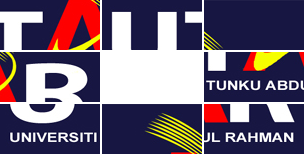

'The result after applying the provided solution list'

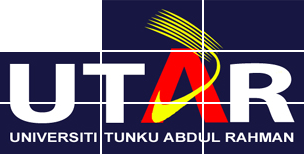

In [9]:
# When you have a solution, you can test it as below. The solution list is
# a consecutive list of positions which need to be shifted to the current empty
# slot. The solution shown below is the solution for the puzzle generated by
# the random seed 1234567.

# Do note that this cell and the student ID in cell 2 are the ONLY cells you are
# allowed to edit. Malicious edits for the purpose of creating a fake solution
# will be treated as disciplinary offenses.
# solution = [(0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (1, 1), (1, 0), (2, 0),
#             (2, 1), (1, 1), (0, 1), (0, 0), (1, 0), (1, 1), (0, 1), (0, 2),
#             (1, 2), (1, 1), (1, 0), (0, 0), (0, 1), (1, 1), (1, 2), (0, 2),
#             (0, 1), (0, 0), (1, 0), (1, 1), (0, 1), (0, 2), (1, 2), (1, 1),
#             (1, 0), (0, 0), (0, 1), (1, 1), (1, 2), (0, 2), (0, 1), (0, 0)]

final = copy.deepcopy(starting_point)
display('The starting point of 8 puzzle')
display_single_image(final)
display('The result after applying the provided solution list')
display_single_image(apply_solution_to_image_matrix(final, solutionList))